# Set up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
# Test if GPU is available
import torch
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

True
12.1


In [6]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import utility_functions as utils
import GLM
from DataLoader import Allen_dataset
# from GLM import FC_GPFA

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [7]:
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv, conv_subspace

# Generate simulated spike trains from GLM neurons

In [8]:
### Generate data
torch.manual_seed(0)
np.random.seed(0)

MAX_FIRING_RATE = 10
gt_neuron_params = {'baseline_fr':0.05, 'ntrial':1000, 'narea':6, 'nneuron_area':5, 
                    'nt':300, 'npadding':30}
ntrial = gt_neuron_params['ntrial']
nneuron = gt_neuron_params['narea']*gt_neuron_params['nneuron_area']
nneuron_area = gt_neuron_params['nneuron_area']
narea = gt_neuron_params['narea']

coupling_filter_params = {'peaks_max':10.2, 'num':3, 'nonlinear':0.5}
basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
basis_coupling = basis_coupling[:,:1]

max_histories = basis_coupling.shape[0]
nt = gt_neuron_params['nt'] + gt_neuron_params['npadding']
coupling_mat = np.zeros((max_histories, nneuron, nneuron))
baseline_mat = np.zeros((nt, nneuron))
spikes = np.zeros((ntrial, nneuron, nt))
log_firing_rate_rcd = np.zeros((ntrial, nneuron, nt))

### Generate coupling matrix
for jarea in range(gt_neuron_params['narea']):
    baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area] = np.log(gt_neuron_params['baseline_fr'])
    # baseline_mat[:, jarea*nneuron_area:(jarea+1)*nneuron_area] = baseline_fr*np.random.rand(nt, nneuron_area)
    for iarea in range(narea):
        # if jarea == iarea+1 and jarea in [1]:
        if iarea == 0 and jarea != iarea:
            coupling_mat[:, iarea*nneuron_area:(iarea+1)*nneuron_area, jarea*nneuron_area:(jarea+1)*nneuron_area] \
                = np.flip(1*basis_coupling[:,0])[:, np.newaxis, np.newaxis]/nneuron_area

### Generate time-varying coupling strength coefficients
gt_latent_params = {'sigma2':4, 'nlatent':1, 'offset':0.5, 'L':200}
nlatent = gt_latent_params['nlatent']
offset = gt_latent_params['offset']
project_w = (np.random.uniform(low=-1, high=1, size=(narea, narea, nlatent)))
project_w *= 2/np.sqrt(np.sum(project_w**2))
K_gt = get_K(nt=nt, L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
latents = np.random.multivariate_normal(np.zeros(nt), K_gt, (ntrial, nlatent))
time_varying_coef = np.einsum('ijl, mlt -> ijmt', project_w, latents) + offset

### Generate spikes
for itrial in range(ntrial):
    spikes_single_trial = np.zeros((nt, nneuron, 1))
    log_firing_rate = copy.copy(baseline_mat[:,:,np.newaxis])
    spikes_single_trial[0,:,0] = np.random.poisson(np.exp(log_firing_rate[0,:,0]))

    for t in range(1, nt):
        nhistories = min(t, max_histories)
        temp_log_firing_rate = (coupling_mat[-nhistories:, :, :] \
            * np.kron(time_varying_coef[:,:,itrial,t][np.newaxis,:,:], np.ones((nneuron_area, nneuron_area))) \
                * spikes_single_trial[(t-nhistories):(t), :, :]).sum(axis=(0, 1))
        log_firing_rate[t,:,0] += temp_log_firing_rate
        log_firing_rate[t,:,0] = np.minimum(log_firing_rate[t,:,0], MAX_FIRING_RATE)
        spikes_single_trial[t,:,0] = np.random.poisson(np.exp(log_firing_rate[t,:,0]))
        # spikes_single_trial[t,:,0] = np.exp(log_firing_rate[t,:,0])

    log_firing_rate = log_firing_rate.squeeze()
    spikes_single_trial = spikes_single_trial.squeeze()
    spikes[itrial, :, :] = spikes_single_trial.T
    log_firing_rate_rcd[itrial, :, :] = log_firing_rate.T
    
print(spikes.max())

spikes_full = spikes
spikes = [spikes_full[:,iarea*nneuron_area:(iarea+1)*nneuron_area,:] for iarea in range(narea)]

import pandas as pd
window_size = 10
for i in range(narea):
    smoothed_spikes = pd.Series(spikes[i].mean(axis=(0,1))).rolling(window=window_size).mean()
    plt.plot(smoothed_spikes)
plt.show()

KeyboardInterrupt: 

# Communication subspace

In [ ]:
# Input needed: spikes, narea, nneuron_area

# Define the model
class FC_GPFA(nn.Module):
    def __init__(self, spikes, latents=None, nlatent=None, npadding=None, K=None, initialized_with_gt=False, 
                 use_gt_offset=False, nsubspace=1, device='cpu'):
            """
            Initialize the FC_GPFC class.

            Parameters:
            spikes (list): A list of spike data for each population.
            latents (ndarray, optional): Latent variables. Defaults to None.
            fix_latent (bool, optional): Flag indicating whether to fix the latent variables. Defaults to False.
            nlatent (int, optional): Number of latent variables. Defaults to None.
            npadding (int, optional): Number of padding time points. Defaults to None.
            """
            
            super(FC_GPFA, self).__init__()
            self.device = device
            self.spikes = [torch.tensor(spike, dtype=torch.float32, device=self.device) for spike in spikes]
            self.spikes_full = torch.concat(self.spikes, axis=1)
            self.npop = len(self.spikes)
            self.ntrial, _, self.nt = self.spikes[0].shape
            self.npadding = npadding
            self.nt -= self.npadding
            self.nneuron = [spike.shape[1] for spike in spikes]
            self.tot_neuron = sum(self.nneuron)
            self.accnneuron = [0]+np.cumsum(self.nneuron).tolist()
            self.mu = None
            self.hessian = None
            self.use_gt_offset = use_gt_offset
            self.nsubspace = nsubspace
            self.coupling_outputs_subspace = [[None]*self.npop for _ in range(self.npop)]
            self.coupling_outputs = [[None]*self.npop for _ in range(self.npop)]
            
            if latents is not None:
                self.nlatent = latents.shape[1]
                self.latents = torch.tensor(latents, dtype=torch.float32, device=self.device)
            else:
                self.K = torch.from_numpy(K).float().to(self.device)
                self.nlatent = nlatent
                self.latents = torch.zeros(self.ntrial, self.nlatent, self.nt, dtype=torch.float32, device=self.device)
            
            self.estep_weight = torch.zeros(self.ntrial, self.tot_neuron, self.nlatent, self.nt, device=self.device)
            self.estep_bias = torch.zeros(self.ntrial, self.tot_neuron, self.nt, device=self.device)
            
            # Initialize the latents_readout and time_varying_coef_offset
            ###############################################
            if initialized_with_gt:
                # self.latents_readout = nn.Parameter(torch.from_numpy(project_w).float().to(device))
                self.latents_readout = nn.Parameter(torch.zeros(self.npop, self.npop, self.nlatent, device=self.device))
                self.time_varying_coef_offset = nn.Parameter(torch.zeros(self.npop, self.npop, 1, 1, device=device))
                with torch.no_grad():
                    for i in range(self.npop):
                        self.latents_readout[0,i,0] = project_w[0,i,0]
                        self.time_varying_coef_offset[0,i,0,0] = gt_latent_params['offset']
            else:
                self.latents_readout = nn.Parameter(0.01 * (torch.randn(self.npop, self.npop, self.nlatent, device=self.device) * 2 - 1))
                self.time_varying_coef_offset = nn.Parameter(0.1 * (torch.randn(self.npop, self.npop, 1, 1, device=self.device) * 2 - 1))
            ###############################################
            
            coupling_filter_params = {'peaks_max':10.2, 'num':3, 'nonlinear':0.5}
            basis_coupling = GLM.make_pillow_basis(**coupling_filter_params)
            basis_coupling = basis_coupling[:,:1]
            self.basis_coupling = torch.tensor(basis_coupling, dtype=torch.float32, device=self.device)
            
            self.beta_coupling = nn.ModuleList([
                nn.ParameterList([
                        nn.Parameter(0.2*torch.ones(basis_coupling.shape[1], self.nsubspace, device=self.device))
                    for jpop in range(self.npop)])
                for ipop in range(self.npop)])
            
            self.weight_sending = nn.ModuleList([
                nn.ParameterList([
                        nn.Parameter(1/np.sqrt(self.nneuron[ipop]*self.nsubspace)*\
                            torch.ones(self.nneuron[ipop], self.nsubspace, device=self.device))
                    for jpop in range(self.npop)])
                for ipop in range(self.npop)])
            
            self.weight_receiving = nn.ModuleList([
                nn.ParameterList([
                        nn.Parameter(1/np.sqrt(self.nneuron[jpop]*self.nsubspace)*\
                            torch.ones(self.nneuron[jpop], self.nsubspace, device=self.device))
                    for jpop in range(self.npop)])
                for ipop in range(self.npop)])
            
            self.beta_inhomo = nn.ParameterList([
                nn.Parameter(self.spikes[jpop].mean(axis=(0,2))[None,:,None])
                for jpop in range(self.npop)])
            
            # self.coupling_filters = [[torch.einsum('ij,jkl->ikl', self.basis_coupling, self.beta_coupling[ipop][jpop]).transpose(0,1)
            #     for jpop in range(self.npop)] for ipop in range(self.npop)]
    
    def forward(self):
        
        # basis_coupling, beta_coupling -> coupling_filters
        self.coupling_filters = [[torch.einsum('tb,bs->ts', self.basis_coupling, self.beta_coupling[ipop][jpop])
            for jpop in range(self.npop)] for ipop in range(self.npop)]
        
        # Generate time-varying coupling strength coefficients
        # self.time_varying_coef = torch.einsum('ijl,lmt -> ijmt', self.latents_readout, self.latents) + gt_latent_params['offset']
        self.time_varying_coef = torch.einsum('ijl,mlt -> ijmt', self.latents_readout, self.latents) + self.time_varying_coef_offset

        # coupling_outputs in subspace, weight_receving, time_varying_coef (total coupling effects) -> log_firing_rate
        self.log_firing_rate = [torch.zeros(self.ntrial, self.nneuron[jpop], self.nt, device=self.device) 
                                for jpop in range(self.npop)]
        for jpop in range(self.npop):
            for ipop in range(self.npop):
                if ipop == jpop:
                    continue
                # spikes(mit), coupling_filters(ts), weight_sending(is) -> coupling_outputs in subspace(mst)
                self.coupling_outputs_subspace[ipop][jpop] = torch.einsum('mist,is->mst', 
                            conv_subspace(self.spikes[ipop], self.coupling_filters[ipop][jpop], npadding=self.npadding),
                            self.weight_sending[ipop][jpop]
                )
                # print(self.coupling_outputs_subspace.shape)
                # print(self.weight_receiving[ipop][jpop].shape)
                self.coupling_outputs[ipop][jpop] = torch.einsum('mst,js->mjt', 
                                                self.coupling_outputs_subspace[ipop][jpop],
                                                self.weight_receiving[ipop][jpop],
                )
                self.log_firing_rate[jpop] += self.coupling_outputs[ipop][jpop] * self.time_varying_coef[ipop, jpop, :, None, :]
        
        # inhomo -> log_firing_rate
        ###############################################
        if self.use_gt_offset:
            for jpop in range(self.npop):
                self.log_firing_rate[jpop] += np.log(gt_neuron_params['baseline_fr'])
        else:
            for jpop in range(self.npop):
                self.log_firing_rate[jpop] += self.beta_inhomo[jpop]
        ###############################################
        return self.log_firing_rate
    
    def m_step(self, lr=1e-1, max_iter=1000, tol=1e-4, only_get_loss=False, verbose=False):
        ### Define loss function and optimizer
        self.criterion = nn.PoissonNLLLoss(log_input=True)
        self.optimizer = optim.SGD(self.parameters(), lr=lr)
        
        best_loss = float('inf')
        no_improvement_count = 0
        print_epoch = (max(1,int(max_iter/10)))
        
        for epoch in (range(max_iter)):
            # self.normalize()
            self.optimizer.zero_grad()
            outputs = self()
            loss = 0
            # loss += huber_loss_parameter*huber_loss(model.latents_readout, huber_loss_zeros)
            
            for i in range(len(outputs)):
                # print()
                loss += self.criterion(outputs[i], self.spikes[i][:,:,gt_neuron_params['npadding']:])
                # for j in range(len(outputs)):
                #     loss += PENAL_beta_coupling*model.beta_coupling[i][j].pow(2).sum()
                
            if only_get_loss:
                return loss
            loss.backward()
            self.optimizer.step()
            
            # Print progress
            if verbose and (epoch) % print_epoch == 0:
                print(f'Epoch [{epoch}/{num_M_iter}], Loss: {loss.item():.4f}')
                
            # Check if loss has improved
            if loss < best_loss-tol:
                best_loss = min(loss, best_loss)
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                if verbose and no_improvement_count >= 3:
                    print(f"No improvement for three epochs. Stopped training at {epoch}.")
                    return best_loss
                    
        if verbose:
            print(f"Stopped training because of reaching maximum number of iterations.")
        return loss
        
    def e_step(self, lr=1e-2, max_iter=10, tol=1e-2, verbose=False):
        # Get the best latents under the current model
        with torch.no_grad():
            outputs = self()
            # weight: mnlt
            # bias: mnt
            weight = torch.zeros(self.ntrial, self.tot_neuron, self.nlatent, self.nt, device=self.device)
            ###############################################
            if self.use_gt_offset:
                bias = np.log(gt_neuron_params['baseline_fr'])*torch.ones(self.ntrial, self.tot_neuron, self.nt, device=self.device)
            else:
                bias = torch.zeros(self.ntrial, self.tot_neuron, self.nt, device=self.device)
                for jpop in range(self.npop):
                    bias[:, self.accnneuron[jpop]:self.accnneuron[jpop+1], :] += self.beta_inhomo[jpop]
            ###############################################
            for ipop in range(self.npop):
                for jpop in range(self.npop):
                    if ipop == jpop:
                        continue
                    weight[:, self.accnneuron[jpop]:self.accnneuron[jpop+1], :, :] += \
                        self.coupling_outputs[ipop][jpop][:,:,None,:]*self.latents_readout[None, None, ipop, jpop, :, None]
                    bias[:, self.accnneuron[jpop]:self.accnneuron[jpop+1], :] += \
                        self.coupling_outputs[ipop][jpop]*self.time_varying_coef_offset[ipop, jpop, 0, 0]
                    # raise ValueError("Unfinished")

            self.mu, self.hessian, self.lambd, self.elbo = gpfa_poisson_fix_weights(self.spikes_full[:,:,self.npadding:], weight, self.K, 
                                                                        initial_mu=self.mu, initial_hessian=self.hessian, bias=bias, 
                                                                        lr=lr, max_iter=max_iter, tol=tol, verbose=verbose)
            self.latents = self.mu
        return self.elbo
    
    def get_loss(self):
        with torch.no_grad():
            loss = model.m_step(only_get_loss=True)
        return loss
    
    def normalize(self):
        # Normalize the nonidentifiable parameters
        with torch.no_grad():
            for ipop in range(self.npop):
                for jpop in range(self.npop):
                    # beta_coupling need to have unit norm and overall positive
                    ratio = (1/torch.sqrt(self.beta_coupling[ipop][jpop].pow(2).sum()))**(1e-1)\
                        *(1 if self.beta_coupling[ipop][jpop].mean()>=0 else -1)
                    assert ratio != 0, ValueError("Ratio shouldn't be zero when normalizing beta_coupling.")
                    self.beta_coupling[ipop][jpop] *= ratio
                    self.latents_readout[ipop, jpop, :] *= 1/ratio
                    self.time_varying_coef_offset[ipop, jpop, :,:] *= 1/ratio
                    
                    # weight_sending need to have unit norm and overall positive
                    ratio = (1/torch.sqrt(self.weight_sending[ipop][jpop].pow(2).sum()))**(1e-1)\
                        *(1 if self.weight_sending[ipop][jpop].mean()>=0 else -1)
                    assert ratio != 0, ValueError("Ratio shouldn't be zero when normalizing beta_coupling.")
                    self.weight_sending[ipop][jpop] *= ratio
                    self.latents_readout[ipop, jpop, :] *= 1/ratio
                    self.time_varying_coef_offset[ipop, jpop, :,:] *= 1/ratio
                    
                    # weight_receiving need to have unit norm and overall positive
                    ratio = (1/torch.sqrt(self.weight_receiving[ipop][jpop].pow(2).sum()))**(1e-1)\
                        *(1 if self.weight_receiving[ipop][jpop].mean()>=0 else -1)
                    assert ratio != 0, ValueError("Ratio shouldn't be zero when normalizing beta_coupling.")
                    self.weight_receiving[ipop][jpop] *= ratio
                    self.latents_readout[ipop, jpop, :] *= 1/ratio
                    self.time_varying_coef_offset[ipop, jpop, :,:] *= 1/ratio
                    
    def get_ci(self, alpha=0.05):
        self.std = torch.sqrt(torch.diagonal(-torch.linalg.inv(self.hessian), dim1=-2, dim2=-1))
        z = scipy.stats.norm.ppf(1-alpha/2)
        self.ci = [self.mu - z * self.std, self.mu + z * self.std]
        self.ci_time_varying_coef = [
            torch.einsum('ijl,mlt -> ijmt', self.latents_readout, self.ci[0]) + self.time_varying_coef_offset, 
            torch.einsum('ijl,mlt -> ijmt', self.latents_readout, self.ci[1]) + self.time_varying_coef_offset
            ]

################### Training hyperparameter ###################
initialized_with_gt = False
use_gt_offset = False

torch.manual_seed(0)
print_epoch = 100
penal_beta_coupling = 1e-3

num_EM_epochs = 30
EM_tol = 1e-4

num_M_iter = 1000
M_tol = 1e-4
M_lr = 1e-1
num_E_iter = 1000
E_tol = 1e-4
E_lr = 1e-1
################################################################

# huber_loss_parameter = 0e-2
# huber_loss = nn.HuberLoss(delta=0.02, reduction='sum')
# huber_loss_zeros = torch.zeros_like(model.latents_readout)

### Instantiate the model
K = get_K(nt=gt_neuron_params['nt'], L=gt_latent_params['L'], sigma2=gt_latent_params['sigma2'])
# model = FC_GPFA(spikes, latents=latents[:,:,gt_neuron_params['npadding']:], npadding=gt_neuron_params['npadding'])
model = FC_GPFA(spikes, K=K, nlatent=1, npadding=gt_neuron_params['npadding'], device=device, 
                initialized_with_gt=initialized_with_gt, use_gt_offset=use_gt_offset)
if initialized_with_gt:
    model.latents = torch.tensor(latents[:,:,gt_neuron_params['npadding']:], dtype=torch.float32, device=device)

best_loss = float('inf')
for EM_epoch in range(num_EM_epochs):    
    # M-step
    loss = model.m_step(lr=M_lr, max_iter=num_M_iter, tol=M_tol, verbose=False)
    print(f"Final loss after {EM_epoch}th M-step: {loss.item():.4f}")
    
    # E-step
    model.normalize()
    elbo = model.e_step(lr=E_lr, max_iter=num_E_iter, tol=E_tol, verbose=False)
    print(f"ELBO after {EM_epoch}th E-step: {elbo:.4f}")
    loss = model.get_loss()
    print(f"Final loss after {EM_epoch}th E-step: {loss.item():.4f}")
    print(f"*********************************")
    
    if loss >= best_loss - EM_tol:
        print(f"Converged after {EM_epoch}th EM-step.")
        break
    best_loss = loss

model.get_ci()

### Ground truth loss
loss_gt = 0
for i in range(model.npop):
    loss_gt += model.criterion(torch.tensor(log_firing_rate_rcd[:,:,gt_neuron_params['npadding']:], device=device), 
                        model.spikes_full[:,:,gt_neuron_params['npadding']:])
print(f"ground truth loss: {loss_gt.item()}")

Final loss after 0th M-step: 1.3517
ELBO after 0th E-step: -1876426.3750
Final loss after 0th E-step: 1.3498
*********************************
Final loss after 1th M-step: 1.3252
ELBO after 1th E-step: -1840592.8750
Final loss after 1th E-step: 1.3250
*********************************
Final loss after 2th M-step: 1.3143
ELBO after 2th E-step: -1823394.1250
Final loss after 2th E-step: 1.3132
*********************************
Final loss after 3th M-step: 1.3062
ELBO after 3th E-step: -1813160.5000
Final loss after 3th E-step: 1.3061
*********************************
Final loss after 4th M-step: 1.3017
ELBO after 4th E-step: -1805921.7500
Final loss after 4th E-step: 1.3015
*********************************
Final loss after 5th M-step: 1.2980
ELBO after 5th E-step: -1800989.2500
Final loss after 5th E-step: 1.2979
*********************************
Final loss after 6th M-step: 1.2956
ELBO after 6th E-step: -1797197.2500
Final loss after 6th E-step: 1.2955
*********************************

```
ground truth: 1.0746, -1772333.3750
fitted: 1.0733, -1466380.8750
```

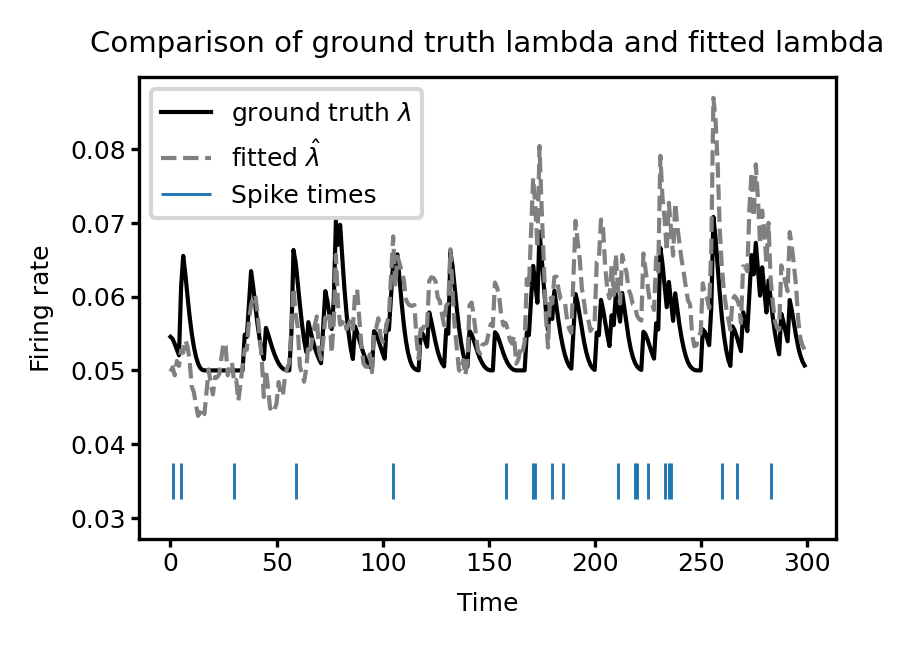

Loss of log_firing_rate_rcd: 0.24580854667898347
Loss of outputs: 0.2441015988588333


In [ ]:
trial_to_plot = 34

utils.use_pdf_plot()
plt.figure(figsize=(3,2), dpi=300)
plt.plot(np.exp(log_firing_rate_rcd[trial_to_plot,-1,gt_neuron_params['npadding']:]), color='k', label='ground truth $\lambda$')
plt.plot(np.exp(model.log_firing_rate[-1].detach().cpu().numpy()[trial_to_plot, -1, :]), '--', color='grey', label='fitted $\hat{\lambda}$')
plt.eventplot(np.where(spikes[-1][trial_to_plot, -1, gt_neuron_params['npadding']:]>0), lw=0.7, label='Spike times', lineoffsets=0.035, linelengths=0.005)
plt.xlabel('Time')
plt.ylabel('Firing rate')
plt.title('Comparison of ground truth lambda and fitted lambda')
plt.legend()
# plt.ylim([0.03, 0.09])
# plt.savefig('Figure/example of overfitting.pdf', format='pdf', dpi=300)
plt.show()

# Calculate the loss
loss_rcd = model.criterion(torch.tensor(log_firing_rate_rcd[trial_to_plot,-1,gt_neuron_params['npadding']:], device=device), 
                     model.spikes[-1][trial_to_plot, -1, gt_neuron_params['npadding']:])
loss_outputs = model.criterion(torch.tensor(model.log_firing_rate[-1].detach().cpu().numpy()[trial_to_plot, -1, :], device=device), 
                         model.spikes[-1][trial_to_plot, -1, gt_neuron_params['npadding']:])
print("Loss of log_firing_rate_rcd:", loss_rcd.item())
print("Loss of outputs:", loss_outputs.item())



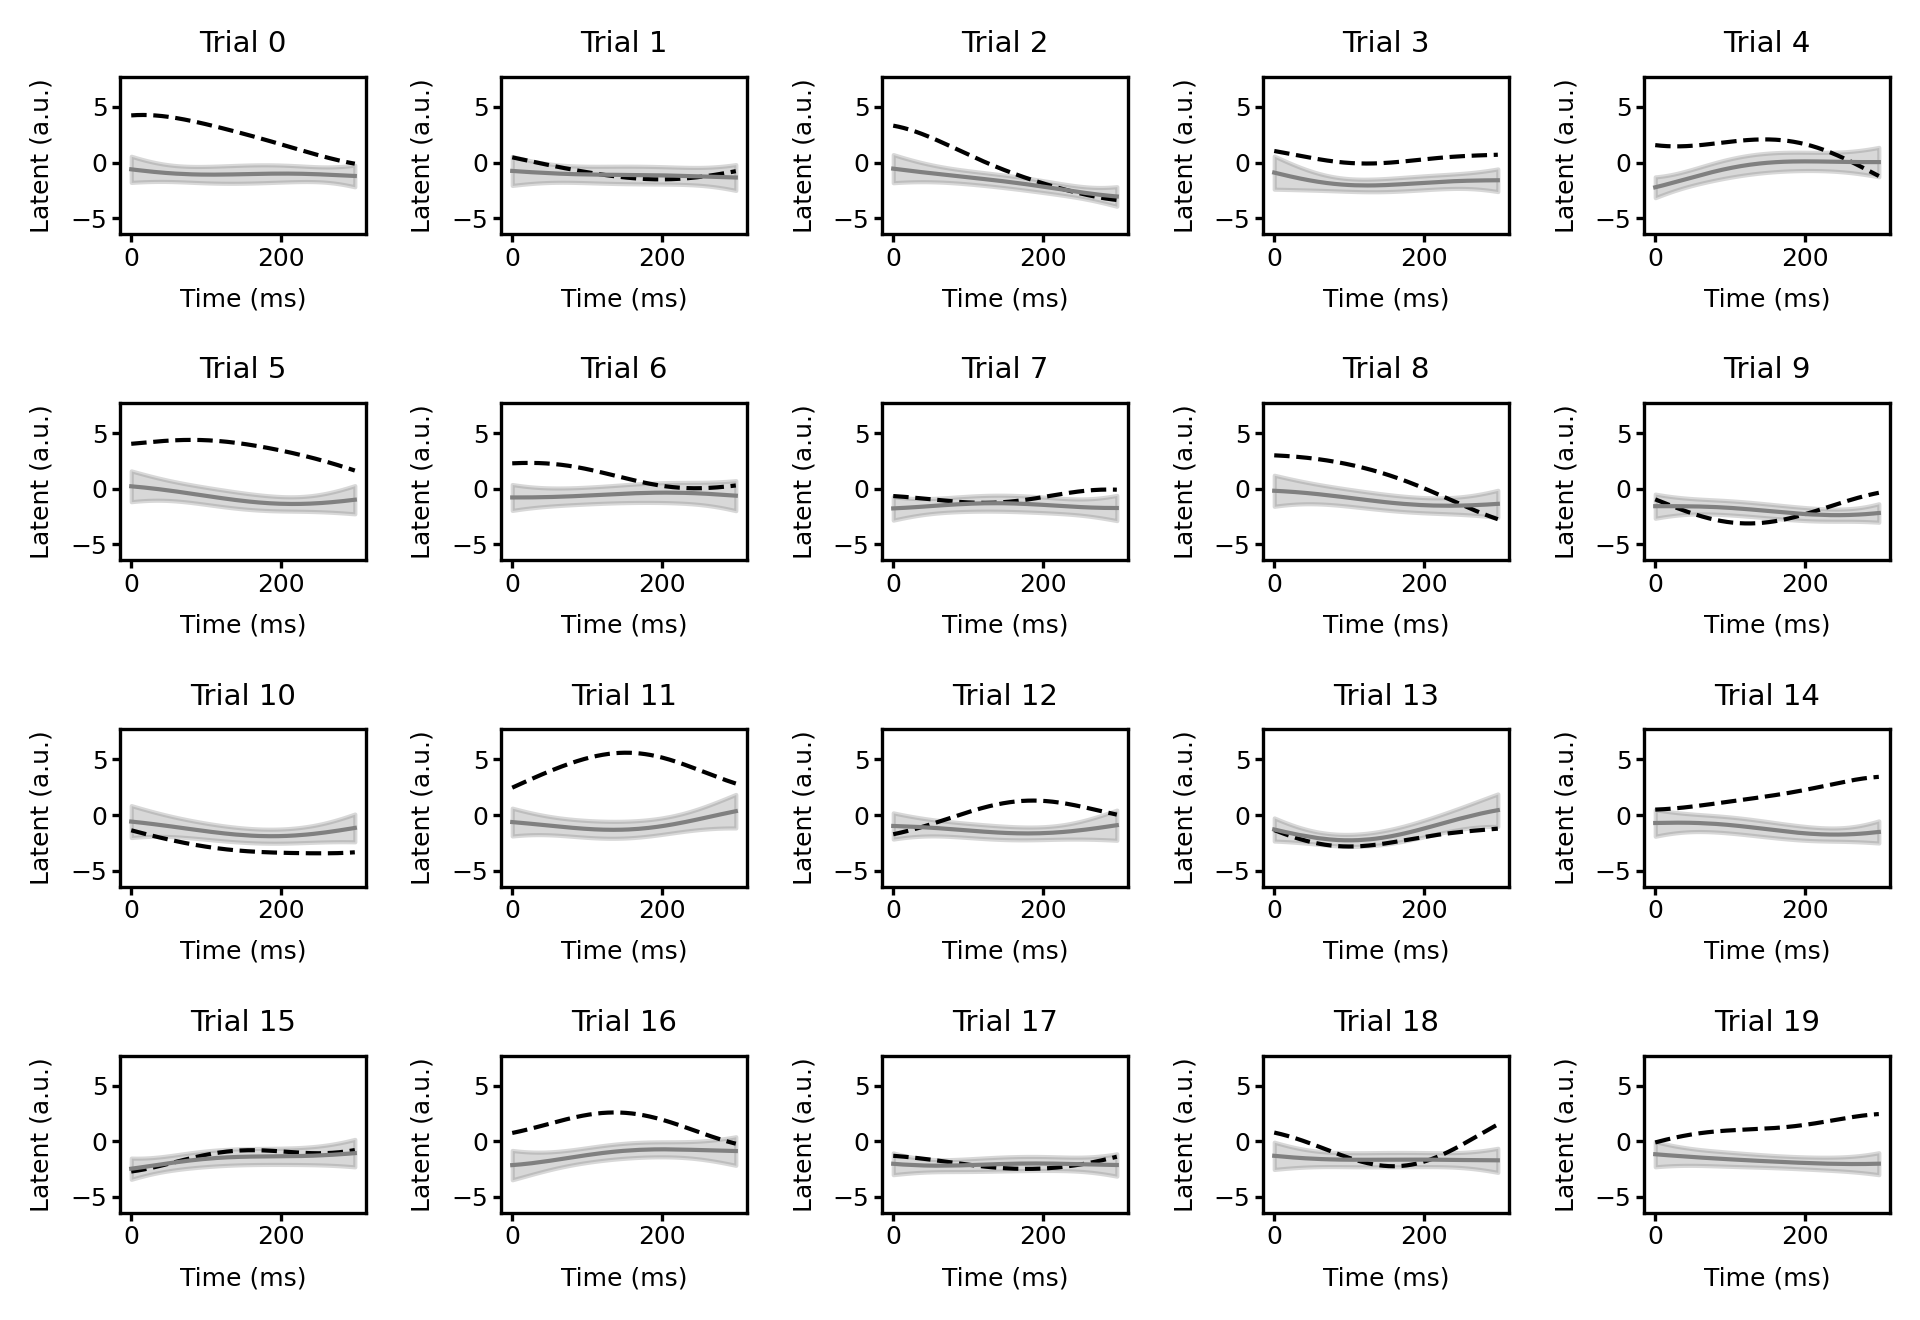

In [ ]:
import matplotlib. pyplot as plt
from matplotlib import rcParams, rcParamsDefault

utils.use_pdf_plot()
plt.figure(figsize=(6.5, 4.5), dpi=300)

# Get the maximum and minimum values of latents
latents_min = latents[:, 0, model.npadding:].min()
latents_max = latents[:, 0, model.npadding:].max()

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.plot(-latents[i, 0, model.npadding:], '--', label='latents', color='k')
    plt.plot(model.mu[i, 0, :].cpu().numpy(), label='fitted latents', color='grey')
    plt.fill_between(range(model.nt), 
                     model.ci[0][i, 0, :].cpu().numpy(), 
                     model.ci[1][i, 0, :].cpu().numpy(), 
                     alpha=0.3, color='grey')
    plt.xlabel('Time (ms)')
    plt.ylabel('Latent (a.u.)')
    plt.title(f'Trial {i}')
    plt.ylim(latents_min, latents_max)  # Set the same y-axis limits for each subplot
    # if i==0:
    #     plt.legend()

plt.tight_layout()
# plt.savefig('Figure/good converge example latents.pdf', format='pdf', dpi=300)
plt.show()

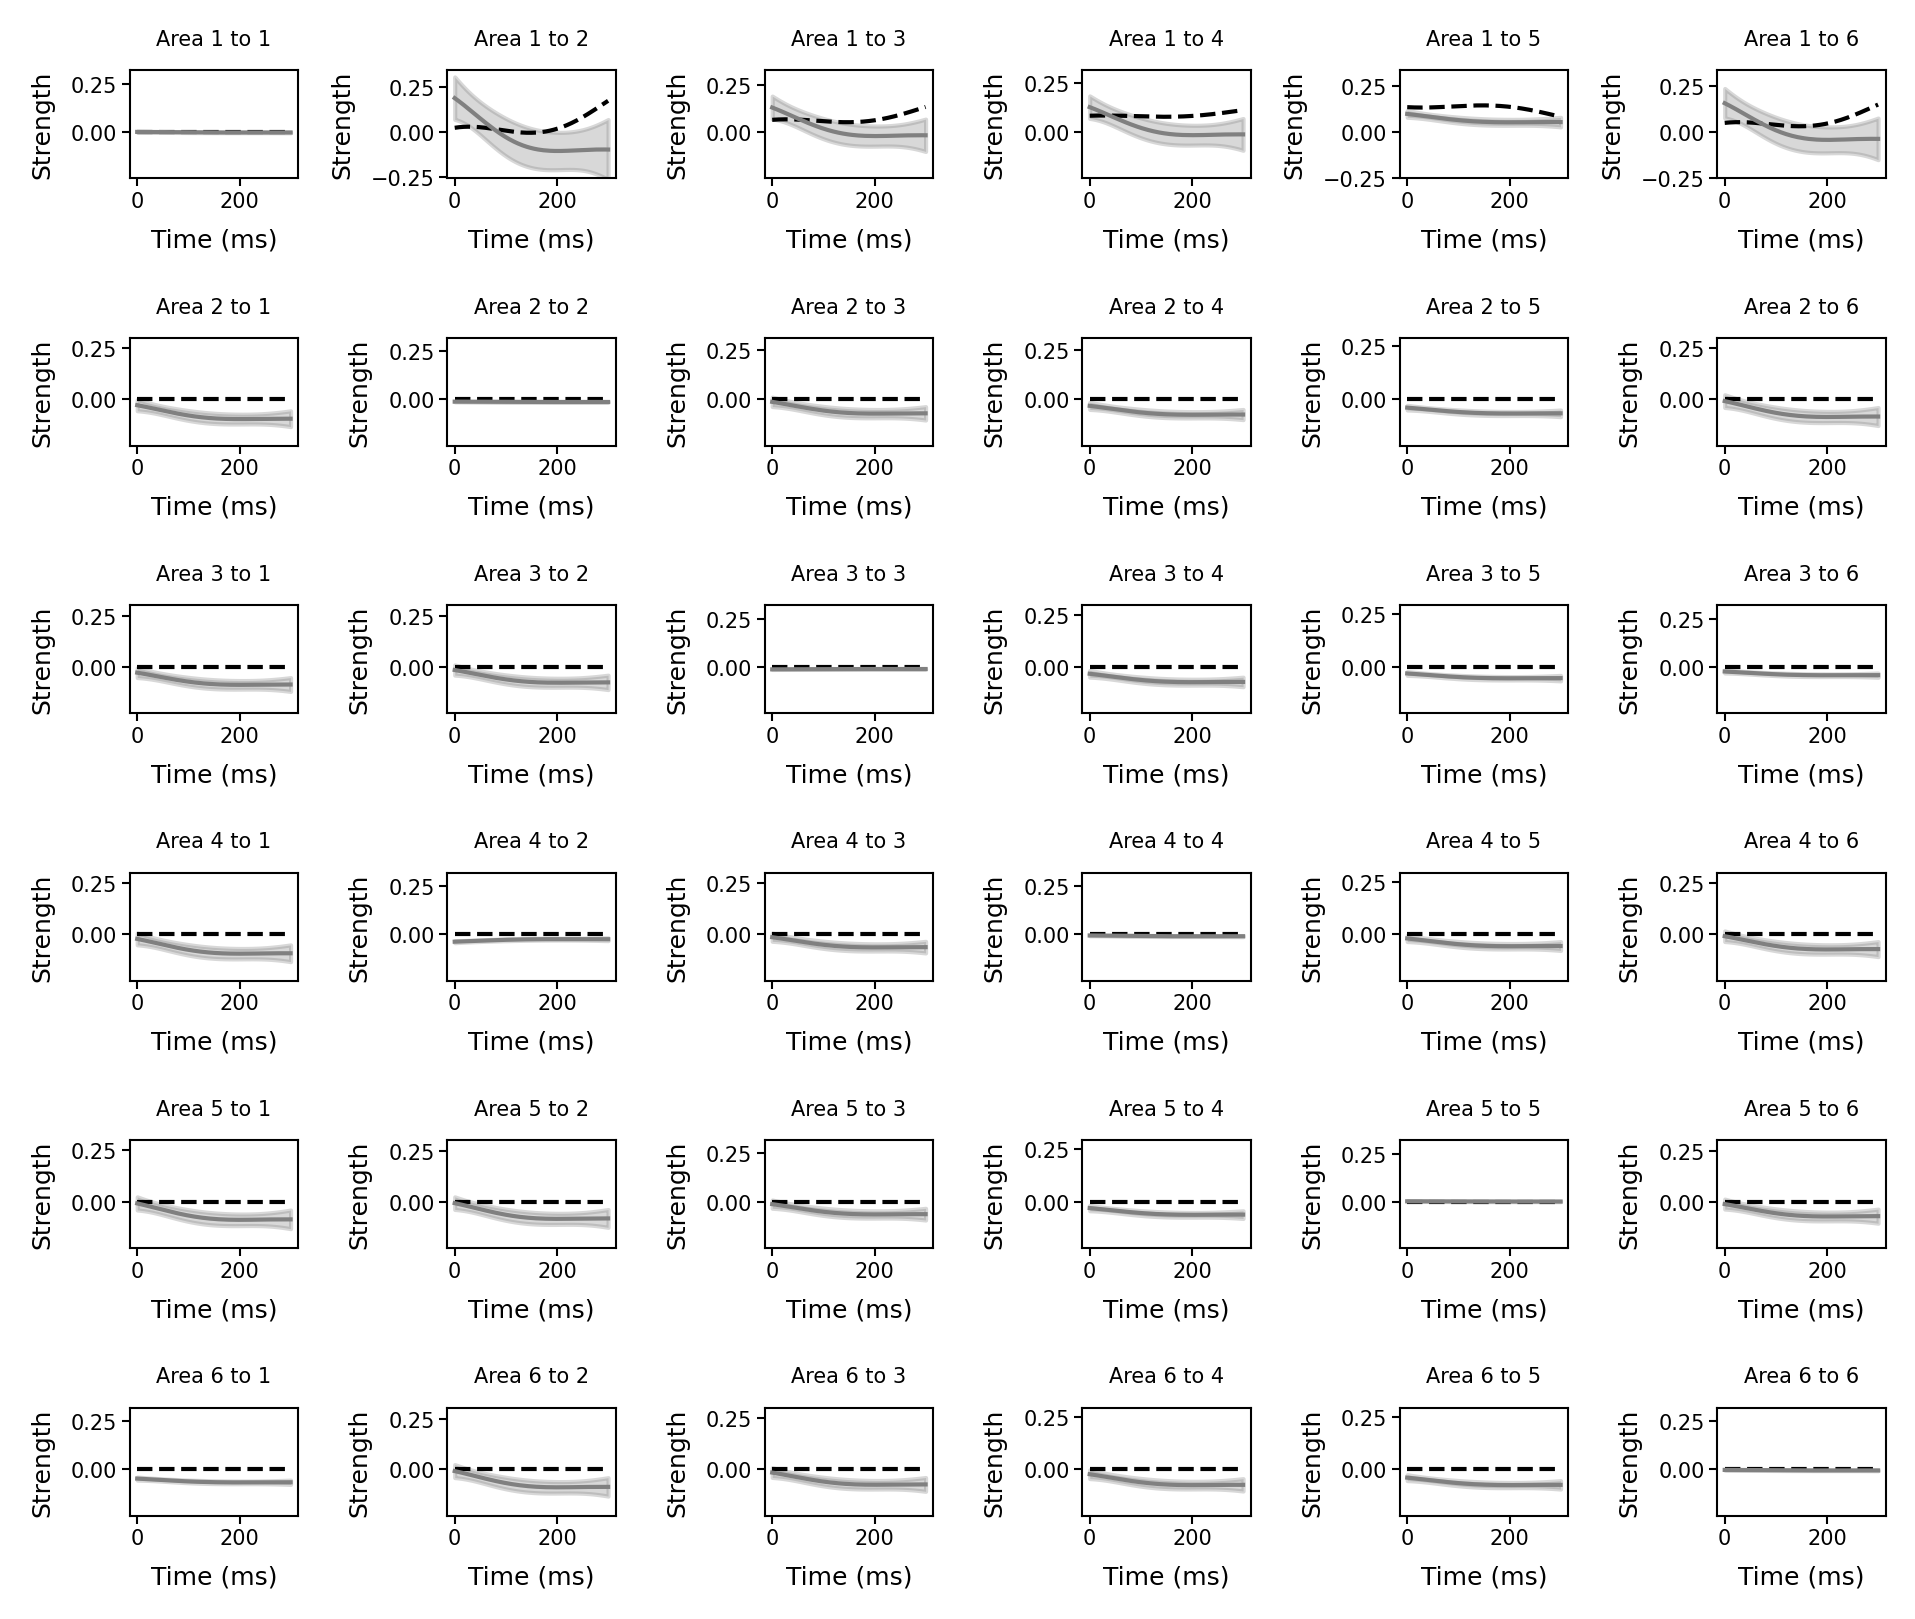

In [ ]:
utils.use_pdf_plot(**{'axes.linewidth':0.5, 'xtick.labelsize':5, 'ytick.labelsize':5})

trial = 4
fig, axs = plt.subplots(narea, narea, figsize=(6.5, 5.5), dpi=300)
for i in range(narea):
    for j in range(narea):
        multiplier = model.weight_sending[i][j].mean().detach().cpu().numpy()\
            *model.weight_receiving[i][j].mean().detach().cpu().numpy()
        axs[i, j].plot(multiplier*time_varying_coef[i, j, trial, model.npadding:].T*(i==0 and j!=0), '--k')
        axs[i, j].plot(multiplier*model.time_varying_coef[i, j, trial, :].detach().cpu().numpy(),'-',color='grey')
        # axs[i, j].set_ylim([-0.2, 1.2])
        axs[i, j].fill_between(range(model.nt), 
                    multiplier*model.ci_time_varying_coef[0][i, j, trial, :].detach().cpu().numpy(), 
                    multiplier*model.ci_time_varying_coef[1][i, j, trial, :].detach().cpu().numpy(), 
                    alpha=0.3, color='grey')
        axs[i, j].set_title(f'Area {i+1} to {j+1}', fontsize=5)
        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Strength')
        axs[i, j].set_ylim(-1.2*multiplier, 1.6*multiplier)
        # axs[i, j].set_xticks([0, 150, 300])

plt.tight_layout()
# plt.savefig('Figure/good converge example coupling strength.pdf', format='pdf', dpi=300)
plt.show()


In [ ]:
model.weight_receiving[0][1], model.weight_sending[0][1]

(Parameter containing:
 tensor([[0.4314],
         [0.4773],
         [0.4648],
         [0.4794],
         [0.4589]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[0.4604],
         [0.4317],
         [0.4622],
         [0.4927],
         [0.4644]], device='cuda:0', requires_grad=True))

In [ ]:
for iarea in range(1, narea):
    print(f"weight from 0 to {iarea}: {model.latents_readout[0,iarea,0].item()}, {project_w[0,iarea,0]}")
    print(f"offest from 0 to {iarea}, {model.time_varying_coef_offset[0,iarea,0].item()}, {gt_latent_params['offset']}")
    
print(model.beta_inhomo[0])

weight from 0 to 1: -0.5862855911254883, 0.25121633062262094
offest from 0 to 1, -0.43195101618766785, 0.5
weight from 0 to 2: -0.3163454234600067, 0.11996800164573374
offest from 0 to 2, -0.07432897388935089, 0.5
weight from 0 to 3: -0.3107190728187561, 0.052397517262215386
offest from 0 to 3, -0.05181516334414482, 0.5
weight from 0 to 4: -0.09297852218151093, -0.08912690015330711
offest from 0 to 4, 0.25772619247436523, 0.5
weight from 0 to 5: -0.40678027272224426, 0.170319678717845
offest from 0 to 5, -0.16352203488349915, 0.5
Parameter containing:
tensor([[[-2.7126],
         [-2.7371],
         [-2.7086],
         [-2.7306],
         [-2.7210]]], device='cuda:0', requires_grad=True)


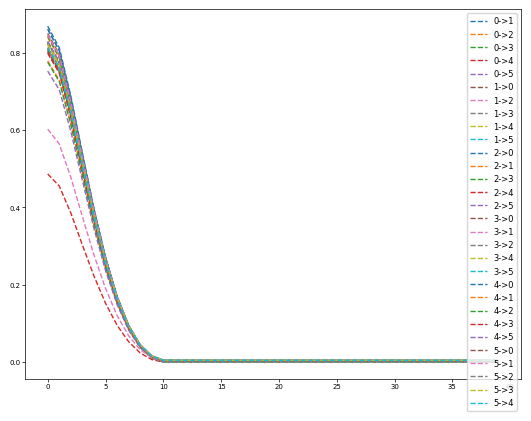

In [ ]:
# for iarea in range(narea-1):
#     plt.plot(model.coupling_filters[iarea][iarea+1][:,:,0].mean(axis=0).detach().numpy().T)
eps = 1e-3

for iarea in range(narea):
    for jarea in range(narea):
        if iarea==jarea:
            continue
        plt.plot(model.coupling_filters[iarea][jarea].flatten().detach().cpu().numpy().T + eps*iarea, 
                 "--", lw=1, label=f'{iarea}->{jarea}')
plt.legend()
plt.show()

# Transformer

```
Average pooling every token is clearly better than using the embedding of a cls token. 
linear decoder or a two layer decoder not sure.
dropout and beta are hyperparameter.
whether model.train=False or True not sure either. 
```

```
Good parameters: 
with linear decoder, no dropout, average pooling, beta=0 and model.train=False

params = {
    'num_merge':5,
    'batch_size':4,
    ### GLM parameters
    'num_B_spline_basis':30,
    ### Transformer encoder parameters
    'nl_dim':10,
    'num_layers':4,
    'dim_feedforward':64,
    'nfactor':5,
    'nhead':1,
    ### Training parameters
    'learning_rate':1e-4,
    'learning_rate_decoder':1e-3,
    'dropout':0.0,
    'warm_up_epoch':5,
    'max_epoch':100,
    'patience_epoch':5,
}
```

```
When using lr=1e-3; 1e-1, the model just converge to the trivial solution (always output mean) with 0.316 and 0.319 as training loss and test loss

When lr=1e-4; 1e-2, the model looks better with 0.0299 and 0.0308 as training and test loss. 
```

In [2]:
# Train a model
import numpy as np
import socket
import utility_functions as utils
import pickle
from model_trainer import Trainer
import torch
import matplotlib.pyplot as plt

### Load data
session_id = 757216464
stimuli_name = ''
# stimuli_name = 'gabors'
npadding = 100

hostname = socket.gethostname()
if hostname[:8] == "ghidorah":
    path_prefix = '/home'
elif hostname[:6] == "wright":
    path_prefix = '/home/export'
ckp_path = path_prefix+'/qix/user_data/FC-GPFA_checkpoint'
with open(path_prefix+'/qix/user_data/allen_spike_trains/'+str(session_id)+'.pkl', 'rb') as f:
    spikes = pickle.load(f)

spikes = [sp[:,:,-(500+npadding):-150] for sp in spikes]

In [3]:
params = {
    'batch_size': 64,
    'beta': 0.2,
    'decoder_architecture': 0,
    'dim_feedforward': 128,
    'dropout': 0.0,
    'learning_rate': 0.001,
    'learning_rate_decoder': 0.01,
    'learning_rate_cp': 0.01,
    'epoch_warm_up': 5,
    'epoch_fix_latent': 100,
    'epoch_patience': 5,
    'epoch_max': 100,
    'nfactor': 32,
    'nhead': 2,
    'nl_dim': 16,
    'num_B_spline_basis': 25,
    'num_layers': 4,
    'num_merge': 10,
    'sample_latent': False,
    'nsubspace': 1,
    'K_tau': 200,
    'K_sigma2': 4.0,
    'nlatent': 1,
    'coupling_basis_num': 3,
    'coupling_basis_peaks_max': 10.2
    }

trainer = Trainer(spikes, ckp_path, params, npadding=npadding)
trainer.train(verbose=True)

Start training model with parameters: {'batch_size': 64, 'beta': 0.2, 'decoder_architecture': 0, 'dim_feedforward': 128, 'dropout': 0.0, 'learning_rate': 0.001, 'learning_rate_decoder': 0.01, 'learning_rate_cp': 0.01, 'epoch_warm_up': 5, 'epoch_fix_latent': 100, 'epoch_patience': 5, 'epoch_max': 100, 'nfactor': 32, 'nhead': 2, 'nl_dim': 16, 'num_B_spline_basis': 25, 'num_layers': 4, 'num_merge': 10, 'sample_latent': False, 'nsubspace': 1, 'K_tau': 200, 'K_sigma2': 4.0, 'nlatent': 1, 'coupling_basis_num': 3, 'coupling_basis_peaks_max': 10.2}
Data processed. Train set size: 480, Test set size: 120
Model initialized. Training on cuda
Epoch 1/100, Train Loss: 0.0400, Test Loss: 0.0405
Epoch 2/100, Train Loss: 0.0388, Test Loss: 0.0386
Epoch 3/100, Train Loss: 0.0369, Test Loss: 0.0368
Epoch 4/100, Train Loss: 0.0357, Test Loss: 0.0361
Epoch 5/100, Train Loss: 0.0351, Test Loss: 0.0357
Epoch 6/100, Train Loss: 0.0347, Test Loss: 0.0354
Epoch 7/100, Train Loss: 0.0345, Test Loss: 0.0351
Epoc

0.033593365798393886

In [ ]:
trainer.model

VAETransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=352, out_features=352, bias=True)
        )
        (linear1): Linear(in_features=352, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=352, bias=True)
        (norm1): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((352,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (to_latent): Linear(in_features=352, out_features=32, bias=True)
  (decoder_fc): Linear(in_features=16, out_features=8064, bias=True)
  (readout_matrices): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_fea

In [4]:
# Compaire the Poisson loss with homogeneous baseline (constant firing rate)
homo_fr = torch.log(trainer.spikes_full_no_padding.mean())
print(f"Homogeneous baseline loss: {torch.mean(torch.exp(homo_fr) - trainer.spikes_full_no_padding * homo_fr):.5f}")
inhomo_fr = torch.log(trainer.spikes_full_no_padding.mean(axis=(0,1)))
print(f"Inhomogeneous baseline loss: {torch.mean(torch.exp(inhomo_fr) - trainer.spikes_full_no_padding * inhomo_fr):.5f}")
firing_rate, mu, std = trainer.predict(return_torch=True, dataset='all')
print(f"My model loss: {torch.mean(torch.exp(firing_rate) - trainer.spikes_full_no_padding * firing_rate):.5f}")
firing_rate, mu, std = trainer.predict(return_torch=True, dataset='train')
print(f"My model training set loss: {torch.mean(torch.exp(firing_rate) - trainer.spikes_full_no_padding[trainer.train_idx,:,:] * firing_rate):.5f}")
firing_rate, mu, std = trainer.predict(return_torch=True, dataset='test')
print(f"My model test set loss: {torch.mean(torch.exp(firing_rate) - trainer.spikes_full_no_padding[trainer.test_idx,:,:] * firing_rate):.5f}")

Homogeneous baseline loss: 0.04019
Inhomogeneous baseline loss: 0.03987
My model loss: 0.03278
My model training set loss: 0.03249
My model test set loss: 0.03375


Best model test set loss: 0.03360

```
trainer.model.training = False
params = {'batch_size': 64,
   'beta': 0.2,
   'dim_feedforward': 128,
   'dropout': 0.0,
   'learning_rate': 0.001,
   'learning_rate_decoder': 0.01,
   'max_epoch': 300,
   'nfactor': 32,
   'nhead': 2,
   'nl_dim': 16,
   'num_B_spline_basis': 25,
   'num_layers': 4,
   'num_merge': 10,
   'patience_epoch': 5,
   'warm_up_epoch': 5}
```

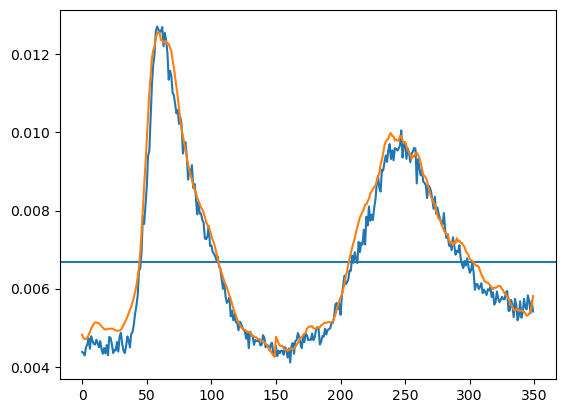

In [5]:
# PSTH
plt.axhline(np.exp(homo_fr))
plt.plot(np.exp(inhomo_fr))
plt.plot(np.exp(firing_rate).numpy().mean(axis=(0,1)))


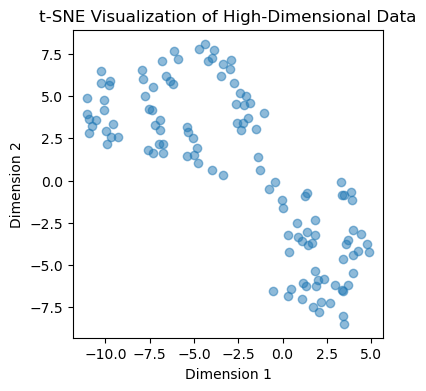

In [6]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(mu)

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(4, 4))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE Visualization of High-Dimensional Data')
plt.show()

In [7]:
mu.std(axis=0) # If mu for each trial are the same, then we only get trivial solution. 

tensor([0.4842, 0.6292, 0.7269, 0.4184, 0.5220, 0.6588, 0.2911, 0.1882, 0.2743,
        0.4458, 0.2470, 0.3982, 0.6657, 0.6566, 0.6452, 0.4849])

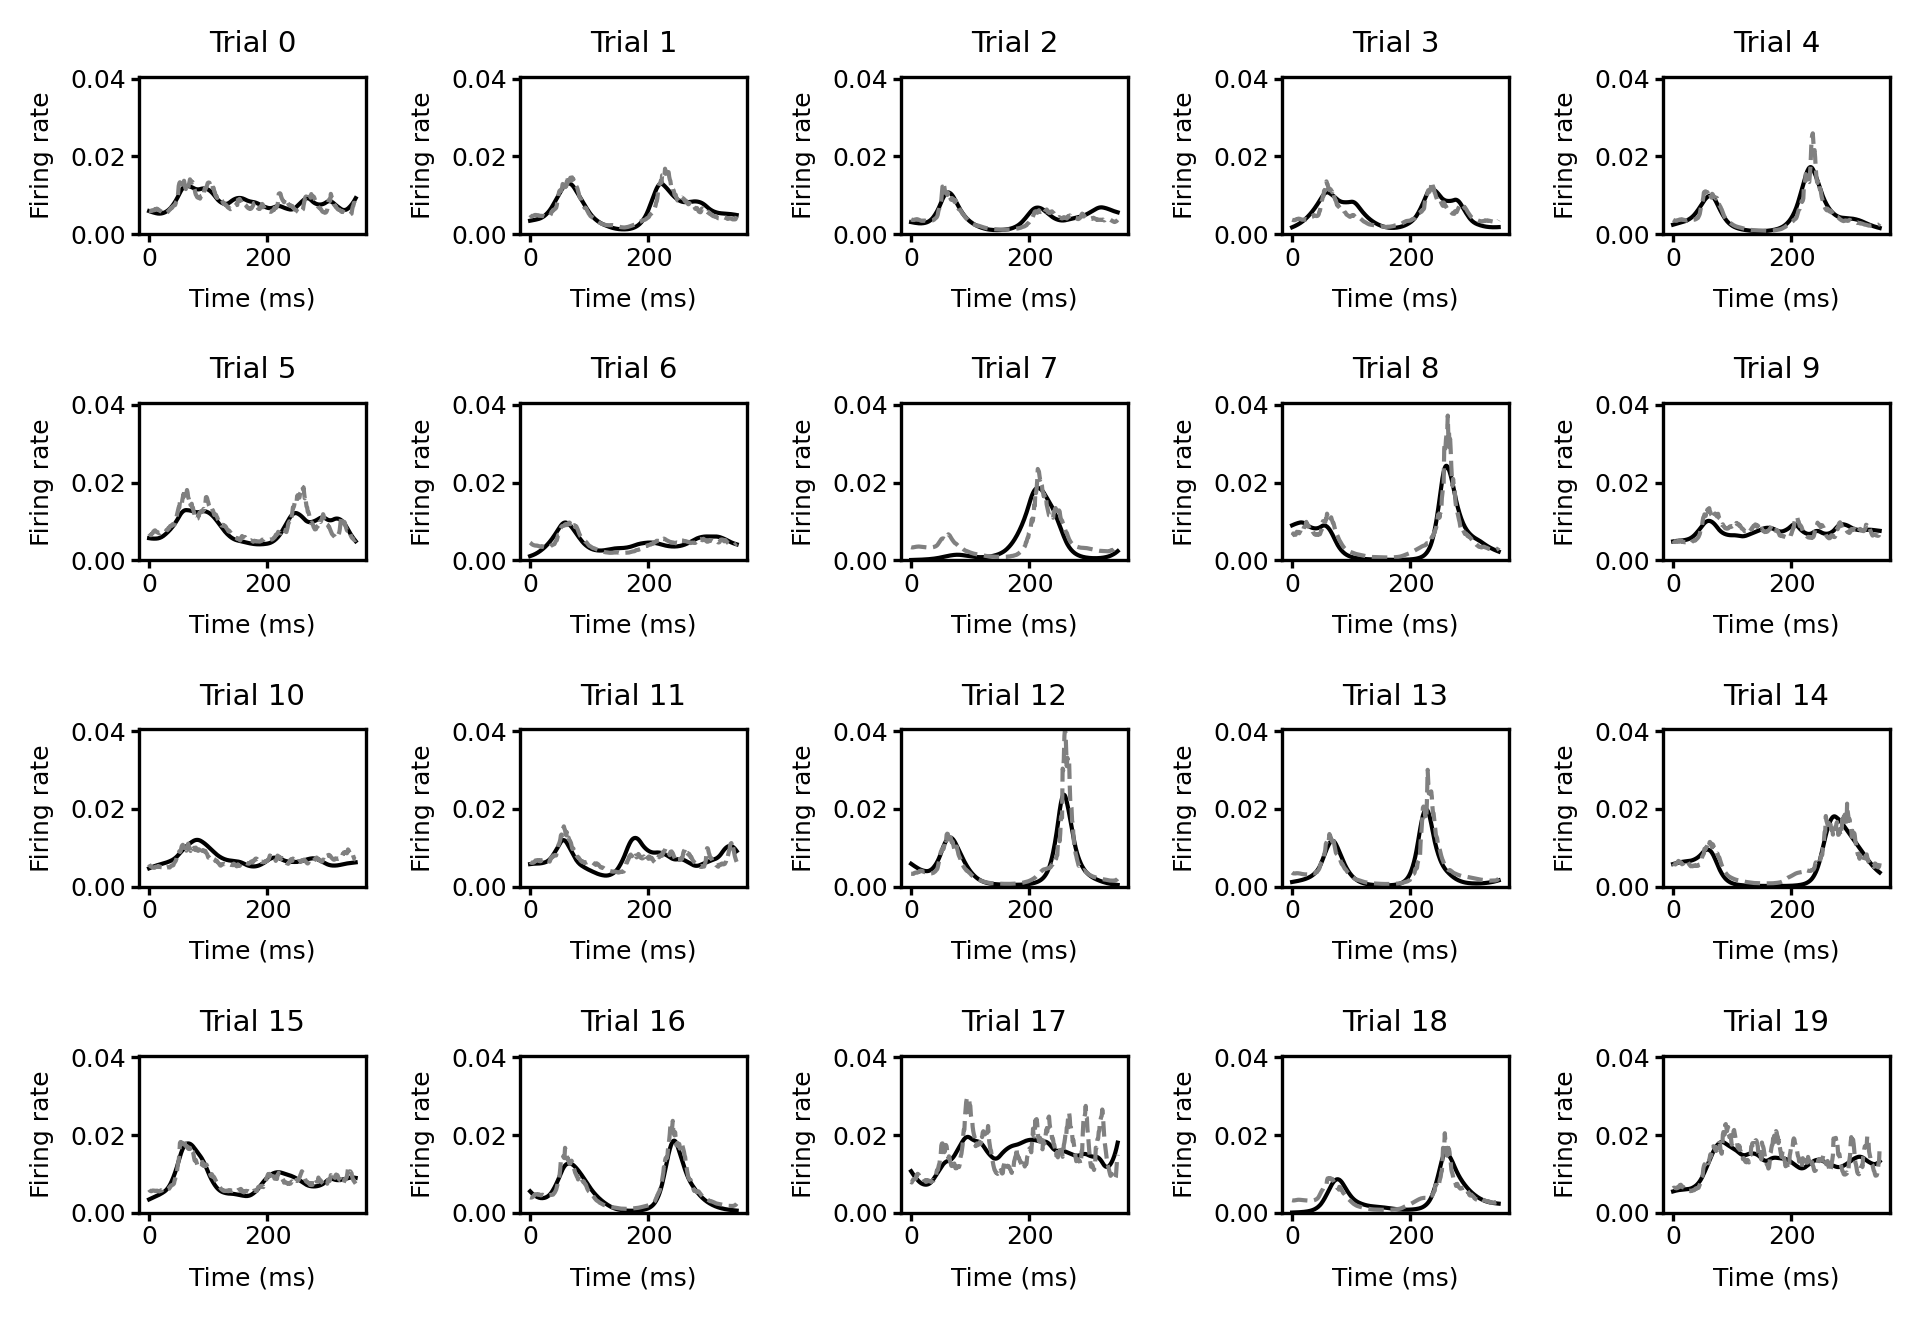

In [10]:
### Compare PSTH of a specific trial in test set
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from GLM import poisson_regression, inhomo_baseline
import matplotlib. pyplot as plt
from matplotlib import rcParams, rcParamsDefault


def spline_smoothing(spikes, spline):
    return poisson_regression(Y=spikes, X=spline, smoothing=1e4,)

utils.use_pdf_plot()
plt.figure(figsize=(6.5, 4.5), dpi=300)
nplot = 20
plot_trial_list = np.arange(nplot)

# Fitted mean firing rate across neuron for a specific trial
firing_rate, mu, std = trainer.predict(return_torch=True, dataset='test')
to_plot_data = np.exp(firing_rate.numpy()).mean(axis=1)
fitted_firing_rate = to_plot_data[plot_trial_list, :]
# Empirical mean firing rate across neuron for a specific trial
mean_spikes = trainer.spikes_full_no_padding.sum(axis=(1)).cpu().numpy()
spline = inhomo_baseline(ntrial=1, start=0, end=trainer.model.nt, dt=1, num=30,
                        add_constant_basis=True)

range_min = 0
range_max = fitted_firing_rate.max()

for i in range(nplot):
    plt.subplot(4, 5, i+1)
    mean_spikes_trial = mean_spikes[trainer.test_idx[i],:]
    empirical_firing_rate = spline@spline_smoothing(mean_spikes_trial, spline).params
    plt.plot(np.exp(empirical_firing_rate)/trainer.spikes_full_no_padding.shape[1], label='experimental', color='k')
    plt.plot(fitted_firing_rate[i,:], '--', label='VAE reconstructed', color='grey')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing rate')
    plt.title(f'Trial {i}')
    plt.ylim(range_min, range_max)  # Set the same y-axis limits for each subplot
    # if i==0:
    #     plt.legend()

plt.tight_layout()
# plt.savefig('Figure/good converge example latents.pdf', format='pdf', dpi=300)
plt.show()


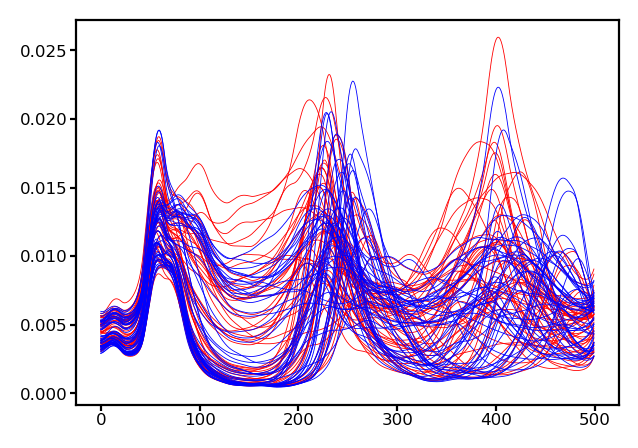

In [ ]:
nplot = int(50)
utils.use_pdf_plot()
plt.figure(figsize=(3.5, 2.5), dpi=200)

firing_rate, mu, std = trainer.predict(return_torch=True, dataset='test')
to_plot_data = np.exp(firing_rate.numpy()).mean(axis=1)[:min(nplot,firing_rate.shape[0]), :].T
for i in range(min(nplot,to_plot_data.shape[1])):
    plt.plot(to_plot_data[:, i], color='red', lw=0.3)  # First 5 lines in red

firing_rate, mu, std = trainer.predict(return_torch=True, dataset='train')
to_plot_data = np.exp(firing_rate.numpy()).mean(axis=1)[:min(nplot,firing_rate.shape[0]), :].T
for i in range(min(nplot,to_plot_data.shape[1])):
    plt.plot(to_plot_data[:, i], color='blue', lw=0.3)  # First 5 lines in red

## Load HP tuning results

In [ ]:
import json

def load_results(results_file):
    results = []
    with open(results_file, 'r') as file:
        current_json = ""
        for line in file:
            # Append line to current JSON text
            current_json += line
            # Check if the line is the end of a JSON object
            if line.strip() == '}':
                # Parse the accumulated JSON text as a JSON object
                results.append(json.loads(current_json))
                # Reset the current JSON text for the next object
                current_json = ""
    return results

filename = trainer.results_file
# filename = 'training_results_no_noise.json'
loaded_results = load_results(filename)


In [ ]:
def get_top_test_loss(results, topn=1):
    # Sort results by the 'test_loss' key (in ascending order for the lowest loss)
    sorted_results = sorted(results, key=lambda x: x['test_loss'])
    # Return the top 5 results with the lowest test loss
    return sorted_results[:topn]

top_results = get_top_test_loss(loaded_results, topn=5)
top_results

[{'params': {'batch_size': 128,
   'beta': 0.4,
   'decoder_architecture': 0,
   'dim_feedforward': 32,
   'dropout': 0.1,
   'learning_rate': 0.0001,
   'learning_rate_decoder': 0.01,
   'max_epoch': 300,
   'nfactor': 64,
   'nhead': 1,
   'nl_dim': 16,
   'num_B_spline_basis': 20,
   'num_layers': 4,
   'num_merge': 10,
   'patience_epoch': 5,
   'sample_latent': False,
   'warm_up_epoch': 5},
  'train_loss': 0.03234558949867884,
  'test_loss': 0.0334051139652729},
 {'params': {'batch_size': 16,
   'beta': 0.1,
   'decoder_architecture': 0,
   'dim_feedforward': 32,
   'dropout': 0.3,
   'learning_rate': 0.0001,
   'learning_rate_decoder': 0.1,
   'max_epoch': 300,
   'nfactor': 32,
   'nhead': 2,
   'nl_dim': 32,
   'num_B_spline_basis': 20,
   'num_layers': 2,
   'num_merge': 20,
   'patience_epoch': 5,
   'sample_latent': False,
   'warm_up_epoch': 5},
  'train_loss': 0.03245404406140248,
  'test_loss': 0.03372652232646942},
 {'params': {'batch_size': 16,
   'beta': 0.0,
   'deco

In [ ]:
! sbatch submit_job.sh

Submitted batch job 492


In [ ]:
!scancel 494

# (abondoned) Get baseline and coupling from real data

In [ ]:
# Load selected group_id
import pickle
with open('group_id_all_a_c/membership.pickle', 'rb') as handle:
    membership = pickle.load(handle)
with open('group_id_all_a_c/condition_ids.pickle', 'rb') as handle:
    condition_ids = pickle.load(handle)

probe_list = ['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF']

# Load data
start_time = 0.0
end_time = 0.50
padding = 0.3
V1 = Allen_dataset(fps=1000,
                   start_time=start_time, 
                   end_time=end_time,
                   padding=padding,
#                    orientation=[0],
                   session_id=757216464,
                   selected_probes=['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'],
#                    temporal_frequency=[1,2,4],
                   stimulus_condition_id=[275, 277, 246, 255, 272, 248, 283, 266, 274, 276, 286, 271, 268, 270],
#                    stimulus_condition_id=[246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 
#                                           262, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277,
#                                           278, 279, 280, 281, 282, 283, 284, 285, 286, 270],
                   stimulus_name='drifting_gratings')

# V1.get_lfp()
# V1.remove_padding(padding)
V1.get_trial_metric_per_unit_per_trial()
# V1.get_trial_metric_per_unit_per_trial(metric_type='spike_times')
V1.get_running(method="mine")

/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/stimulus_table/naming_utilities.py:154: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movie_rows = table[stim_colname].str.contains(movie_re, na=False)
/home/qix/anaconda3/lib/python3.9/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1315: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


In [ ]:
# The following hyperparameters turned out to be the best
num_f_refractory = 4
max_iter = 10
tau = 15
# coupling_filter_params = {'peaks_max':26, 'num':3, 'nonlinear':0.9}
coupling_filter_params = {'peaks_max':20.2, 'num':3, 'nonlinear':0.5}
num_basis_baseline = 20
penalty = 5e-1

################ No need to change below
probe_list = V1.selected_probes

running_model_list = []
stationary_model_list = []

for i, target_probe in tqdm(enumerate(probe_list)):
    select_trials = V1.running_trial_index
    model = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model.add_effect('coupling', probe_list[j], apply_no_penalty=True, **coupling_filter_params)
#     model.add_effect('refractory_additive', target_probe, tau=tau, num=num_f_refractory, apply_no_penalty=True)
    model.add_effect('trial_coef')
    model.fit_time_warping_baseline(target_probe, verbose=False, max_iter=max_iter, penalty=penalty)
    running_model_list.append(model)
    
    select_trials = V1.stationary_trial_index
    model = GLM.PP_GLM(dataset=V1, 
                       select_trials=select_trials, 
                       membership=membership, 
                       condition_ids=condition_ids)
    model.add_effect('inhomogeneous_baseline', num=num_basis_baseline, apply_no_penalty=True)
    for j, input_probe in enumerate(probe_list):
        model.add_effect('coupling', probe_list[j],apply_no_penalty=True, **coupling_filter_params)
#     model.add_effect('refractory_additive', target_probe, tau=tau, num=num_f_refractory, apply_no_penalty=True)
    model.add_effect('trial_coef')
    # model.fit_time_warping_baseline(target_probe, verbose=False, max_iter=max_iter, penalty=penalty)
    model.fit(target_probe, verbose=False, penalty=penalty)
    stationary_model_list.append(model)


6it [00:29,  4.93s/it]


# Unit tests

## Test decoder algorithm

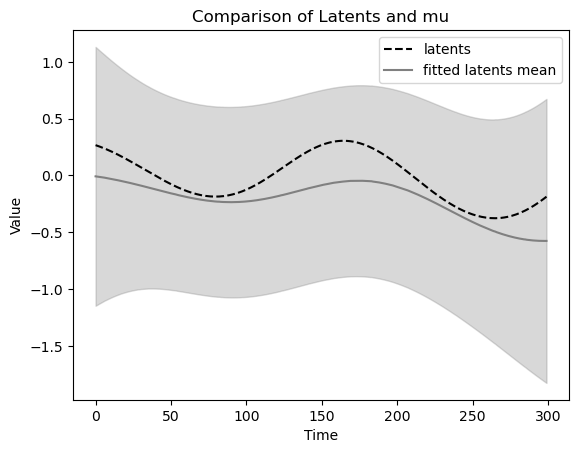

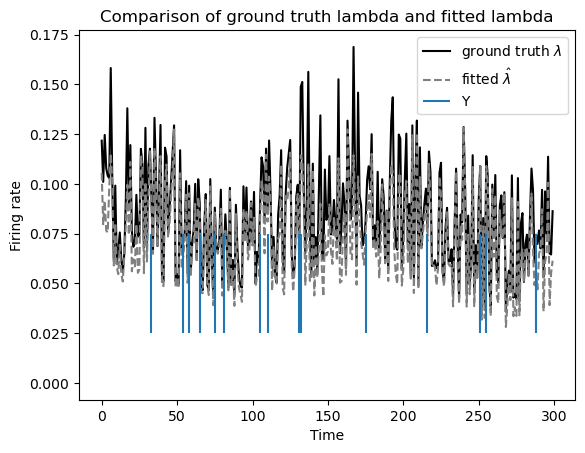

In [ ]:
from FCGPFA import gpfa_poisson_fix_weights, make_4d_diagonal, get_K
from FCGPFA import conv

# Parameters for data generation
ntrial = 1000  # Number of trials
nt = 300    # Number of time bins
nneuron = 2 # Number of neurons
nlatent = 1 # Number of latent variables

# Generate covariance matrix K for the latent variables
K = get_K(nt=nt, L=100)

# Generate latent variables from a multivariate normal distribution
np.random.seed(0)
latents = np.random.multivariate_normal(np.zeros(nt), K, (ntrial, nlatent))
# latents = np.swapaxes(latents, 1, 2)

# Known weights matrix
np.random.seed(0)
# weights = np.abs(np.random.rand(nneuron, nlatent))
# weights = np.repeat(weights[np.newaxis, :, :, np.newaxis], ntrial, axis=0)
# weights = np.repeat(weights, nt, axis=-1)
weights = (np.random.rand(ntrial, nneuron, nlatent, nt))
weights_wrong = weights
# weights_wrong = 2*(np.random.rand(ntrial, nneuron, nlatent, nt))
bias = np.random.rand(ntrial, nneuron, nt)-3
bias_wrong = bias
# bias_wrong = np.random.rand(ntrial, nneuron, nt)+4

# Generate observed spike counts Y
# Calculate the mean of the Poisson distribution
lambd = np.exp(np.einsum('mnlt,mlt->mnt', weights, latents)+bias)
# Sample Y from Poisson distribution
Y = np.random.poisson(lambd)

# Call the function with tensors
mu, hessian, fitted_lambd, loss = gpfa_poisson_fix_weights(torch.from_numpy(Y).float().to(device), 
                                                 torch.from_numpy(weights_wrong).float().to(device), 
                                                 torch.from_numpy(K).float().to(device), 
                                                 bias=torch.from_numpy(bias_wrong).float().to(device),
                                                 max_iter=1000, 
                                                 lr=1e-1,
                                                 verbose=False)

# Conversion for plotting (PyTorch tensor to NumPy array)
mu = mu.cpu().numpy()
hessian = hessian.cpu().numpy()
fitted_lambd = fitted_lambd.cpu().numpy()

# Plotting code remains
trial_to_plot = 5
plt.figure()
plt.plot(latents[trial_to_plot, 0, :], '--', label='latents', color='k')
std = np.sqrt(np.diagonal(-np.linalg.inv(hessian), axis1=-2, axis2=-1))
lower_bound = mu - 1.96 * std
upper_bound = mu + 1.96 * std
plt.plot(mu[trial_to_plot, 0, :], label='fitted latents mean', color='grey')
plt.fill_between(range(nt), lower_bound[trial_to_plot, 0, :], upper_bound[trial_to_plot, 0, :], alpha=0.3, color='grey')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of Latents and mu')
plt.legend()
plt.show()


plt.figure()
plt.plot(lambd[trial_to_plot, 0, :], color='k', label='ground truth $\lambda$')
plt.plot(fitted_lambd[trial_to_plot, 0, :], '--', color='grey', label='fitted $\hat{\lambda}$')
plt.eventplot(np.where(Y[0, 0, :]>0), label='Y', lineoffsets=0.05, linelengths=0.05)
plt.xlabel('Time')
plt.ylabel('Firing rate')
plt.title('Comparison of ground truth lambda and fitted lambda')
plt.legend()
plt.show()
